# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,make_scorer
warnings.filterwarnings("ignore")

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,auc
import lightgbm as lgb
from sklearn import preprocessing

# Utility Functions

In [2]:
def countplot(data,param,fig_nu=False,ax=False):
    plt.rcParams["figure.figsize"] = (10,5)
    
    if fig_nu:
        return sns.countplot(x=param, data=data,ax=ax[fig_nu]).set_title("Distribution of {0}".format(param))
        
    else:
        ax=sns.countplot(x=param, data=data).set_title("Distribution of {0}".format(param))
        plt.show()

def basic_info_csv(data):
  
  numeric_columns=[]
  cat_columns=[]
  for i in data.columns:
    if data[i].dtype=='int' or data[i].dtype=='float':
      numeric_columns.append(i)
    else:
      cat_columns.append(i)

  print("There are total {} rows and {} Columns in the given CSV.".format(data.shape[0],data.shape[1]))
  print("*"*200)
  print("There are {0} columns which contains numerical data and they are: ".format(len(numeric_columns)))
  print(numeric_columns)
  print("There are {0} columns which contains text/categorical data and they are: ".format(len(cat_columns)))
  print(cat_columns)
  print("*"*200)
  print("First 5 Rows of the Dataframe.")
  display(data.head())
  print("*"*200)
  print("DataFrame Description(Pandas Inbuilt Function -> Describe):")
  display(data.describe())
  print("*"*200)
  # print("DataFrame Info(Pandas  Inbuilt Function -> Info): ")
  # display(data.info())
  #print("*"*100)
  print("Missing Data Information")
  missing_values= data.isnull().sum(axis = 1).sum()
  print("There are total {} values missing in the dataframe, which is around {}%.".format(missing_values,round((missing_values/data.shape[0])*100),4))
  missing_df=pd.DataFrame((data.isnull().sum(axis = 0)/data.shape[0])*100,columns=['% Missing']).reset_index()
  missing_df=missing_df.rename(columns={'index':'Column'})
  print("Column wise missing data information.")
  display(missing_df)

  return numeric_columns,cat_columns


# Importing dataset

In [16]:
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
def read_data():
    train_df = pd.read_csv('train.csv')
    test_df =pd.read_csv('test.csv')

    train = train_df.copy()
    test = test_df.copy()

    return train_df,test_df

train_df,test_df=read_data()

# EDA

## Basic statitics 

### Train Dataset

In [4]:
num_col,cat_col = basic_info_csv(train_df)
cat_col = list(set(cat_col)-{'Property_ID'})

There are total 39499 rows and 15 Columns in the given CSV.
********************************************************************************************************************************************************************************************************
There are 8 columns which contains numerical data and they are: 
['Property_Area', 'Number_of_Windows', 'Number_of_Doors', 'Frequency_of_Powercuts', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Habitability_score']
There are 7 columns which contains text/categorical data and they are: 
['Property_ID', 'Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise']
********************************************************************************************************************************************************************************************************
First 5 Rows of the Dataframe.


,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


********************************************************************************************************************************************************************************************************
DataFrame Description(Pandas Inbuilt Function -> Describe):


,Property_Area,Number_of_Windows,Number_of_Doors,Frequency_of_Powercuts,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Habitability_score
count,39499.000000,37845.000000,39499.000000,38116.000000,39499.000000,39499.000000,39499.000000,39499.000000
mean,1391.715638,3.923768,2.331375,0.484678,6.354772,121.352566,3.735945,73.482297
std,1953.287544,2.690992,1.179964,0.752207,1.219681,62.384669,0.796843,14.118753
min,100.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,7.280000
25%,494.000000,2.000000,1.000000,0.000000,5.600000,95.000000,3.220000,69.660000
50%,932.000000,4.000000,2.000000,0.000000,6.470000,113.000000,3.850000,75.760000
75%,1770.000000,5.000000,3.000000,1.000000,7.220000,140.000000,4.260000,82.260000
max,28064.000000,15.000000,6.000000,3.000000,9.910000,1044.000000,5.000000,100.000000


********************************************************************************************************************************************************************************************************
Missing Data Information
There are total 6085 values missing in the dataframe, which is around 15%.
Column wise missing data information.


,Column,% Missing
0,Property_ID,0.000000
1,Property_Type,0.000000
2,Property_Area,0.000000
3,Number_of_Windows,4.187448
4,Number_of_Doors,0.000000
5,Furnishing,2.638041
6,Frequency_of_Powercuts,3.501354
7,Power_Backup,0.000000
8,Water_Supply,0.000000
9,Traffic_Density_Score,0.000000


### Test dataset

In [5]:
_,_ = basic_info_csv(test_df)

There are total 10500 rows and 14 Columns in the given CSV.
********************************************************************************************************************************************************************************************************
There are 7 columns which contains numerical data and they are: 
['Property_Area', 'Number_of_Windows', 'Number_of_Doors', 'Frequency_of_Powercuts', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review']
There are 7 columns which contains text/categorical data and they are: 
['Property_ID', 'Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise']
********************************************************************************************************************************************************************************************************
First 5 Rows of the Dataframe.


,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review
0,0x6e93,Apartment,293,3.0,1,Unfurnished,0.0,No,Once in a day - Morning,7.28,Well above average,Medium,152.0,2.52
1,0x8787,Apartment,586,4.0,1,Semi_Furnished,0.0,No,Once in a day - Evening,7.63,Well below average,Medium,92.0,4.16
2,0x6c17,Container Home,305,1.0,2,Semi_Furnished,1.0,No,All time,5.39,Slightly above average,Medium,90.0,2.92
3,0x9dbd,Apartment,258,2.0,1,Semi_Furnished,1.0,No,All time,7.53,Slightly below average,Medium,158.0,3.45
4,0xbfde,Bungalow,3031,12.0,4,Fully Furnished,0.0,No,All time,8.79,Well above average,High,186.0,2.72


********************************************************************************************************************************************************************************************************
DataFrame Description(Pandas Inbuilt Function -> Describe):


,Property_Area,Number_of_Windows,Number_of_Doors,Frequency_of_Powercuts,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review
count,10500.000000,10055.000000,10500.000000,10134.000000,10500.000000,10500.000000,10500.000000
mean,1364.333333,3.897563,2.326571,0.484409,6.361525,120.532571,3.734125
std,1813.702032,2.690162,1.175324,0.749686,1.216237,55.635990,0.793325
min,100.000000,0.000000,1.000000,0.000000,0.020000,0.000000,0.020000
25%,505.000000,2.000000,1.000000,0.000000,5.620000,95.000000,3.230000
50%,935.500000,3.000000,2.000000,0.000000,6.470000,113.000000,3.850000
75%,1758.000000,5.000000,3.000000,1.000000,7.220000,140.000000,4.220000
max,27477.000000,15.000000,6.000000,3.000000,9.430000,1031.000000,5.000000


********************************************************************************************************************************************************************************************************
Missing Data Information
There are total 1610 values missing in the dataframe, which is around 15%.
Column wise missing data information.


,Column,% Missing
0,Property_ID,0.000000
1,Property_Type,0.000000
2,Property_Area,0.000000
3,Number_of_Windows,4.238095
4,Number_of_Doors,0.000000
5,Furnishing,2.447619
6,Frequency_of_Powercuts,3.485714
7,Power_Backup,0.000000
8,Water_Supply,0.000000
9,Traffic_Density_Score,0.000000


## Univariate Analysis

#### Categorical Variable Distribution

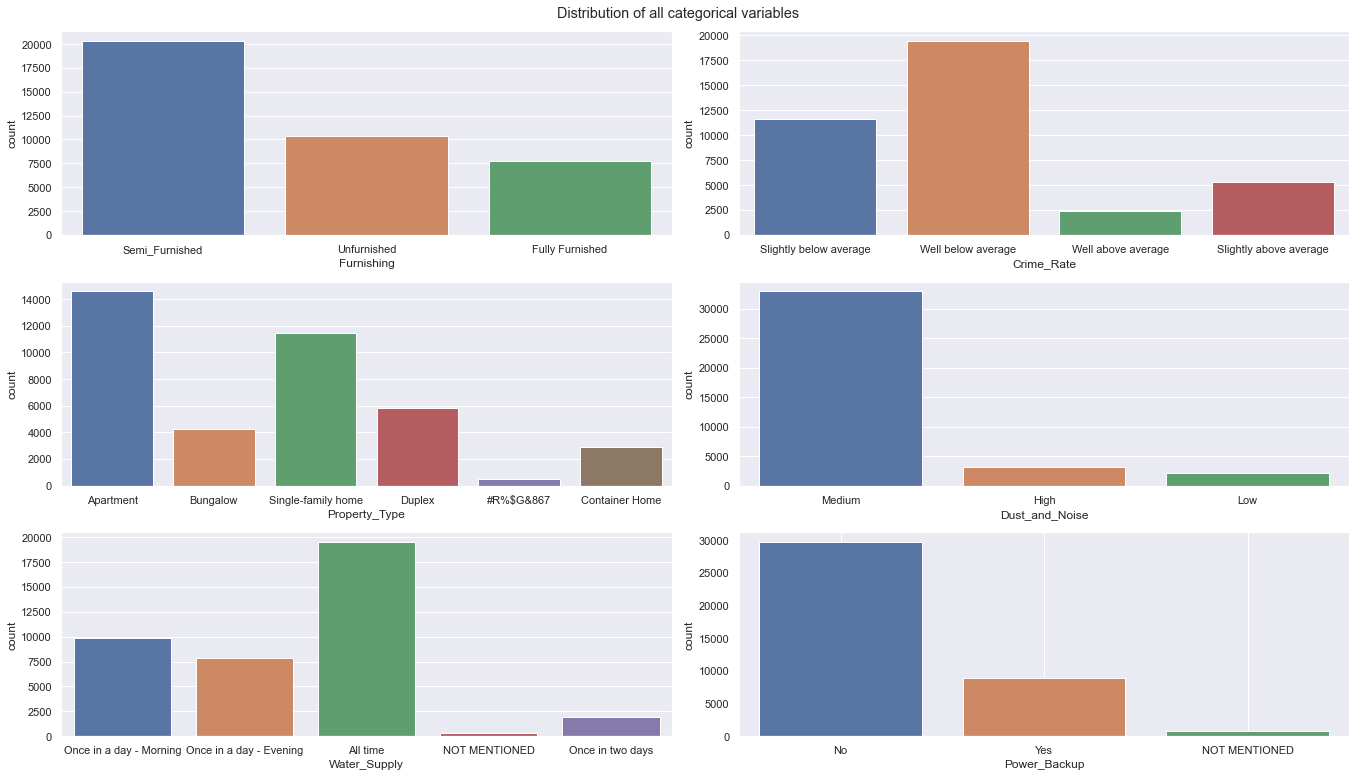

In [6]:

fig, ax =plt.subplots(3,2)
sns.set(rc={'figure.figsize':(19,11)})
ax = ax.flatten()
for idx,col in enumerate(cat_col):
   
    sns.countplot(train_df[col],ax=ax[idx])#.set_title("Distribution of {0}".format(col))
fig.suptitle('Distribution of all categorical variables') 
plt.grid()
fig.tight_layout()

> Observations
1. Most of the properties have medium dust and noise. 
2. Mostly properties are apartment types followed by single-family homes, duplex, bonglow etc
3. Most properties don't have power backups.
4. Most houses are semi furnished.
5. Most houses have water supply all the times.
6. crime rate is well below avergae for most of the properties. 

#### Numerical variable distribution

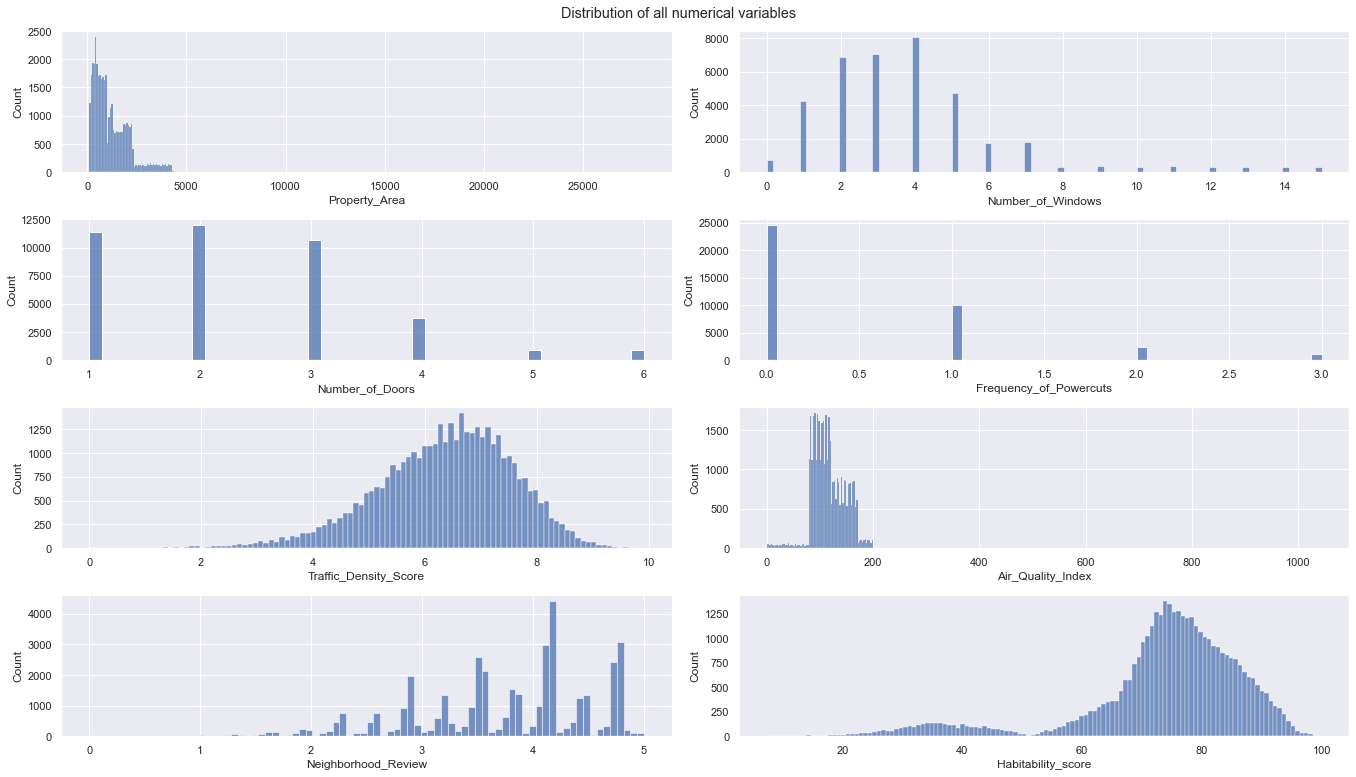

In [7]:
fig, ax =plt.subplots(4,2)
sns.set(rc={'figure.figsize':(19,11)})
ax = ax.flatten()

for idx,col in enumerate(num_col):
   
    sns.histplot(train_df[col],ax=ax[idx])

fig.suptitle('Distribution of all numerical variables') 
plt.grid()
fig.tight_layout()

Log of target

<AxesSubplot:xlabel='Habitability_score', ylabel='Count'>

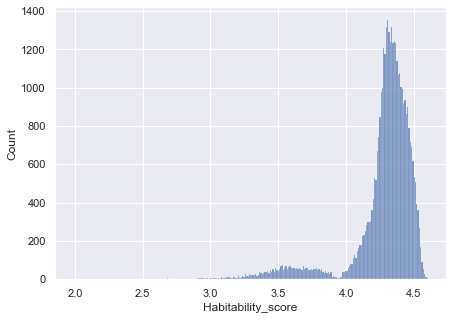

In [70]:
y= 'Habitability_score'
sns.set(rc={'figure.figsize':(7,5)})
sns.histplot(np.log(train_df[y]))

- Don't change anything

Log of AQI

<AxesSubplot:xlabel='Air_Quality_Index', ylabel='Count'>

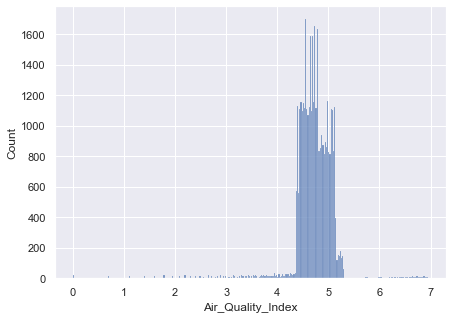

In [71]:
y= 'Air_Quality_Index'
sns.set(rc={'figure.figsize':(7,5)})
sns.histplot(np.log(train_df[y]))

log of property area

<AxesSubplot:xlabel='Property_Area', ylabel='Count'>

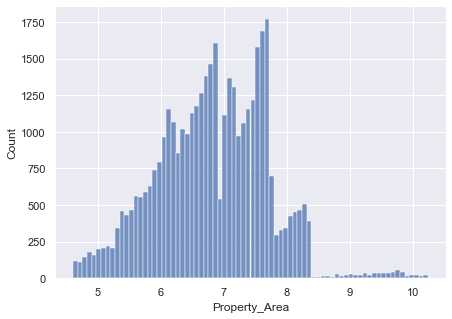

In [72]:
y= 'Property_Area'
sns.set(rc={'figure.figsize':(7,5)})
sns.histplot(np.log(train_df[y]))

- Makes it less skywed 

## Bivariate Analysis

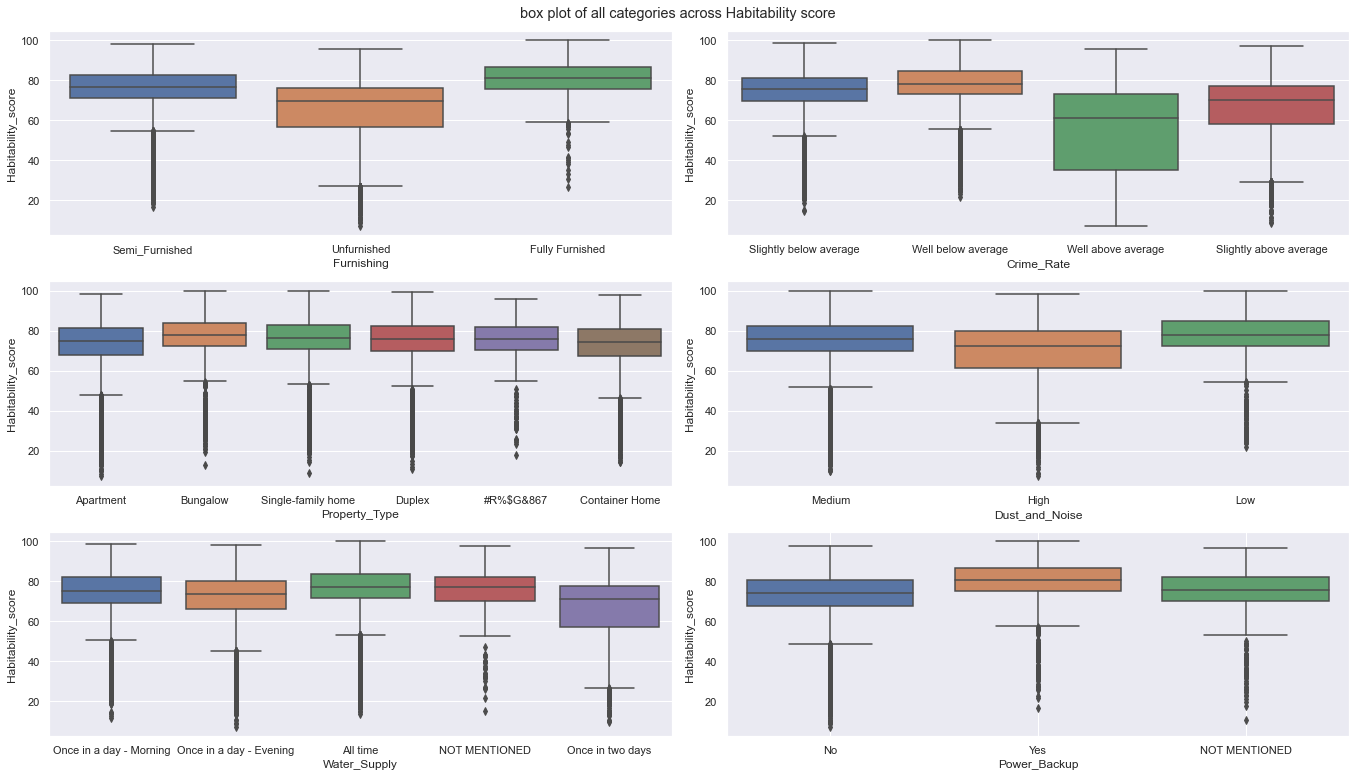

In [8]:
fig, ax =plt.subplots(3,2)
sns.set(rc={'figure.figsize':(19,11)})
ax = ax.flatten()

for idx,col in enumerate(cat_col):
   
    sns.boxplot(x=col, y="Habitability_score",data=train_df,ax=ax[idx])

fig.suptitle('box plot of all categories across Habitability score') 
plt.grid()
fig.tight_layout()

### Data preprocessing

#### Feature Engineering 

Null Values Imputation 

In [75]:

def treat_nans(train_df,test_df):


    train_df['Number_of_Windows'] = np.where(train_df['Number_of_Windows'].isna(),4.0,train_df['Number_of_Windows'])
    train_df['Furnishing'] = np.where(train_df['Furnishing'].isna(),'Semi_Furnished',train_df['Furnishing'])
    train_df['Frequency_of_Powercuts'] = np.where(train_df['Frequency_of_Powercuts'].isna(),0.0,train_df['Frequency_of_Powercuts'])
    train_df['Crime_Rate'] = np.where(train_df['Crime_Rate'].isna(),'Well below average',train_df['Crime_Rate'])
    train_df['Dust_and_Noise'] = np.where(train_df['Dust_and_Noise'].isna(),'Medium',train_df['Dust_and_Noise'])
    
    test_df['Number_of_Windows'] = np.where(test_df['Number_of_Windows'].isna(),4.0,test_df['Number_of_Windows'])
    test_df['Furnishing'] = np.where(test_df['Furnishing'].isna(),'Semi_Furnished',test_df['Furnishing'])
    test_df['Frequency_of_Powercuts'] = np.where(test_df['Frequency_of_Powercuts'].isna(),0.0,test_df['Frequency_of_Powercuts'])
    test_df['Crime_Rate'] = np.where(test_df['Crime_Rate'].isna(),'Well below average',test_df['Crime_Rate'])
    test_df['Dust_and_Noise'] = np.where(test_df['Dust_and_Noise'].isna(),'Medium',test_df['Dust_and_Noise'])

    return train_df,test_df


As per above plots

In [114]:


def feature_engine(train_df,test_df,set1="1"):


    train_df['crime_rate_well_above_average'] = np.where(train_df['Crime_Rate']=='Well above average',0,1)
    train_df['furnishing_unfurnished'] = np.where(train_df['Furnishing']=='Unfurnished',0,1)
    train_df['water_supply_once_in_2_days'] = np.where(train_df['Water_Supply']=='Once in two days',0,1)
    train_df['power_backup_yes'] = np.where(train_df['Power_Backup']=='Yes',1,0)
    train_df['nr_greater_than_3'] = np.where(train_df['Neighborhood_Review']>3,1,0)
    train_df['dust_noise_high'] = np.where(train_df['Dust_and_Noise']=='High',0,1)
    train_df['dust_noise_low'] = np.where(train_df['Dust_and_Noise']=='Low',1,0)
    train_df['inter1'] =train_df['crime_rate_well_above_average']+train_df['dust_noise_high']
    train_df['inter2'] =train_df['nr_greater_than_3']+train_df['dust_noise_low']
    train_df['inter3'] =train_df['nr_greater_than_3']+train_df['dust_noise_low']+train_df['power_backup_yes']
    train_df['inter4'] =train_df['nr_greater_than_3']+train_df['dust_noise_low']+train_df['power_backup_yes']+train_df['furnishing_unfurnished']+train_df['crime_rate_well_above_average']
    train_df['inter5'] =train_df['nr_greater_than_3']+train_df['dust_noise_low']+train_df['power_backup_yes']+\
                        train_df['furnishing_unfurnished']+train_df['crime_rate_well_above_average']+train_df['water_supply_once_in_2_days']

    #train_df['property_area_log']= np.log(train_df['Property_Area'])


    test_df['crime_rate_well_above_average'] = np.where(test_df['Crime_Rate']=='Well above average',0,1)
    test_df['furnishing_unfurnished'] = np.where(test_df['Furnishing']=='Unfurnished',0,1)
    test_df['water_supply_once_in_2_days'] = np.where(test_df['Water_Supply']=='Once in two days',0,1)
    test_df['power_backup_yes'] = np.where(test_df['Power_Backup']=='Yes',1,0)
    test_df['nr_greater_than_3'] = np.where(test_df['Neighborhood_Review']>3,1,0)
    test_df['dust_noise_high'] = np.where(test_df['Dust_and_Noise']=='High',0,1)
    test_df['dust_noise_low'] = np.where(test_df['Dust_and_Noise']=='Low',1,0)
    test_df['inter1'] =test_df['crime_rate_well_above_average']+test_df['dust_noise_high']
    test_df['inter2'] =test_df['nr_greater_than_3']+test_df['dust_noise_low']
    test_df['inter3'] =test_df['nr_greater_than_3']+test_df['dust_noise_low']+test_df['power_backup_yes']
    test_df['inter4'] =test_df['nr_greater_than_3']+test_df['dust_noise_low']+test_df['power_backup_yes']+test_df['furnishing_unfurnished']+test_df['crime_rate_well_above_average']
    test_df['inter5'] =test_df['nr_greater_than_3']+test_df['dust_noise_low']+test_df['power_backup_yes']+\
                        test_df['furnishing_unfurnished']+test_df['crime_rate_well_above_average']+test_df['water_supply_once_in_2_days']

    #test_df['property_area_log']= np.log(test_df['Property_Area'])


    if set1=='1':
        feature_to_drop = ['inter1','inter2','inter3','inter4','crime_rate_well_above_average','furnishing_unfurnished','water_supply_once_in_2_days',
                        'power_backup_yes','nr_greater_than_3','dust_noise_high','dust_noise_low']
    elif set1=='2':
        feature_to_drop= ['inter1','inter2','inter3','inter4']
    else:
        feature_to_drop= []

    train_df.drop(columns=feature_to_drop,axis=0,inplace=True)

    test_df.drop(columns=feature_to_drop,axis=0,inplace=True)

    return train_df,test_df

In [10]:
print("shape of train data after adding features:",train_df.shape)
print("shape of test data after adding features:",test_df.shape)

shape of train data after adding features: (39499, 15)
shape of test data after adding features: (10500, 14)


Aggregating the target from history at categorical level. 

In [7]:
def creating_agg_features(train,test,col,target,time=True):
    #25th Percentile
    def q25(x):
        return x.quantile(0.25)
    #75th Percentile
    def q75(x):
        return x.quantile(0.75)

    #95th Percentile
    def q95(x):
        return x.quantile(0.95)

    #99th Percentile
    def q99(x):
        return x.quantile(0.99)   


    _mean=dict()
    _max=dict()
    _min = dict()
    _median=dict()
    _25 = dict()
    _75 = dict()
    _95 = dict()
    _99 = dict()
    std = dict()



    for i in train.groupby(col)[[target]].mean().reset_index().values:
        
        if time:
            _mean[str(i[0])]=i[1]
        else:
            _mean[int(i[0])]=i[1]
    #min always 0 so discarding 
    for i in train.groupby(col)[[target]].min().reset_index().values:
        if time:
            _min[str(i[0])]=i[1]
        else:
            _min[int(i[0])]=i[1]
    for i in train.groupby(col)[[target]].max().reset_index().values:
        if time:
            _max[str(i[0])]=i[1]
        else:
            _max[int(i[0])]=i[1]
    for i in train.groupby(col)[[target]].median().reset_index().values:
        if time:
            _median[str(i[0])]=i[1]
        else:
            _median[int(i[0])]=i[1]
    for i in train.groupby([col]).agg({target: [q25]}).reset_index().values:
        #print(i)
        if time:
            _25[str(i[0])]=i[1]
        else:
            _25[int(i[0])]=i[1]
    for i in train.groupby([col]).agg({target: [q75]}).reset_index().values:
        if time:
            _75[str(i[0])]=i[1]
        else:
            _75[int(i[0])]=i[1]

    for i in train.groupby([col]).agg({target: [q95]}).reset_index().values:
        if time:
            _95[str(i[0])]=i[1]
        else:
            _95[int(i[0])]=i[1]      

    for i in train.groupby([col]).agg({target: [q99]}).reset_index().values:
        if time:
            _99[str(i[0])]=i[1]
        else:
            _99[int(i[0])]=i[1]
            
    for i in train.groupby([col])[[target]].apply(np.std).reset_index().values:
        if time:
            std[str(i[0])]=i[1]
        else:
            std[int(i[0])]=i[1]           

    train[col+'_mean'] = train[col].map(_mean)
    train[col+'_min'] = train[col].map(_min)
    train[col+'_max'] = train[col].map(_max)
    train[col+'_median'] = train[col].map(_median)
    train[col+'_25th'] = train[col].map(_25)
    train[col+'_75th'] = train[col].map(_75)
    train[col+'_95th'] = train[col].map(_95)
    train[col+'_99th'] = train[col].map(_99)
    train[col+'_stddev'] = train[col].map(std)

    test[col+'_mean'] = test[col].map(_mean)
    test[col+'_min'] = test[col].map(_min)
    test[col+'_max'] = test[col].map(_max)
    test[col+'_median'] = test[col].map(_median)
    test[col+'_25th'] = test[col].map(_25)
    test[col+'_75th'] = test[col].map(_75)
    test[col+'_95th'] = test[col].map(_95)
    test[col+'_99th'] = test[col].map(_99)
    test[col+'_stddev'] = test[col].map(std)
    
    #print(_mean)
    #print(_max)
    

    return train,test

In [8]:

def aggrefeature_engine(train_df,test_df,agg=False):
    

    train_fe = train_df.copy()
    test_fe = test_df.copy()

    if agg == True:

        for col in cat_col:
            train_fe,test_fe = creating_agg_features(train_fe,test_fe,col,'Habitability_score',time=True)

        #print("shape of train data after feature engineering:",train_fe.shape)
        #print("shape of test data after feature engineering:",test_fe.shape)
    else:
        pass


    return train_fe,test_df

#### Feature Encoding

One hot encoding of categorical variables

In [9]:

def ohe_scaling(train_df,test_df):
    train_df['Dust_and_Noise'] = train_df['Dust_and_Noise'].map({'Low':0,'Medium':1,'High':2})
    test_df['Dust_and_Noise'] = test_df['Dust_and_Noise'].map({'Low':0,'Medium':1,'High':2})


    cat_col_ohe = list(set(cat_col)-{'Dust_and_Noise'})

    df_combine = pd.concat([train_df,test_df],axis=0,ignore_index=True)
    df_combine_fe = pd.get_dummies(df_combine,columns=cat_col_ohe,drop_first=False)


    print("shape of combined data after one hot encoding:",df_combine_fe.shape)

    return df_combine_fe


#### Train and Test Split

In [130]:
def get_train_test(train_df,df_combine_fe,scaling=False,log_linear=False):


    X_cols = list(set(df_combine_fe.columns) - {'Property_ID','Habitability_score'})
    y_col = ['Habitability_score']

    X = df_combine_fe.iloc[:len(train_df)][X_cols]
    if log_linear:
        y = np.log(df_combine_fe.iloc[:len(train_df)][y_col])
    else:
        y = df_combine_fe.iloc[:len(train_df)][y_col]

    test_data= df_combine_fe.iloc[len(train_df):][X_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

    if scaling:
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        test_data=scaler.transform(test_data)

    return X_train, X_test, y_train, y_test,test_data,X,y

### Data pipline

In [152]:
train_df,test_df=read_data()
train_df,test_df=treat_nans(train_df,test_df)
train_df,test_df=feature_engine(train_df,test_df,set1="2")

train_df,test_df=aggrefeature_engine(train_df,test_df,agg=True)
df_combined=ohe_scaling(train_df,test_df)

X_train, X_test, y_train, y_test,test_data,X,y=get_train_test(train_df,df_combined,scaling=False)

print("train data matrix shape is :",X_train.shape)
print("train data y shape is : ",y_train.shape)
print("test data matrix shape is : ",X_test.shape)
print("train data y shape is : ",y_test.shape)
print("test data shape is: ",test_data.shape)


shape of combined data after one hot encoding: (49999, 93)
train data matrix shape is : (35549, 91)
train data y shape is :  (35549, 1)
test data matrix shape is :  (3950, 91)
train data y shape is :  (3950, 1)
test data shape is:  (10500, 91)


In [124]:
def plot_error(y_actual,y_pred):
    ax=sns.scatterplot(y_pred,y_actual['Habitability_score'].values)
                
    ax.set(xlabel='prediction', ylabel='actual')
    plt.show()

In [127]:
# model.fit(X,y)
# test_pred = model.predict(test_data)
# final_df=pd.DataFrame()
# final_df['Property_ID'] = test_df['Property_ID']
# final_df['Habitability_score']= test_pred
#final_df.to_csv('submission_log.csv',index=False)

#### Modelling

### Xgb 

In [116]:
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean R2 Score is : %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print("R2_Score for test daata :",r2_score(y_test,y_pred))

Mean R2 Score is : 0.810 (0.008)
R2_Score for test daata : 0.8123774182172075


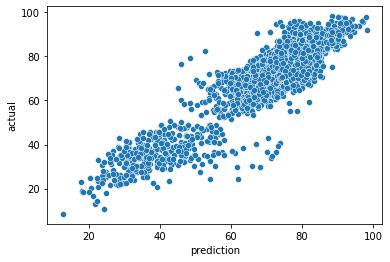

In [125]:
plot_error(y_test,y_pred)

### With Tunning

In [153]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 500, 1000,1500,2000]}

xgbreg = XGBRegressor()

xgb_rscv = RandomizedSearchCV(estimator=xgbreg,
                      cv=5,
                      param_distributions=params,
                      scoring=make_scorer(r2_score, greater_is_better=True),
                      verbose=1,n_jobs=-1)


xgb_rscv.fit(X_train, y_train)

xgb_tunned= xgb_rscv.best_estimator_

y_pred = xgb_tunned.predict(X_train)
y_pred_tes =  xgb_tunned.predict(X_test)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [154]:

print("train score:",r2_score(y_train,y_pred))
print("test score:",r2_score(y_test,np.round(np.ceil(y_pred_tes),2)))

train score: 0.9147610423332448
test score: 0.8270368481896164


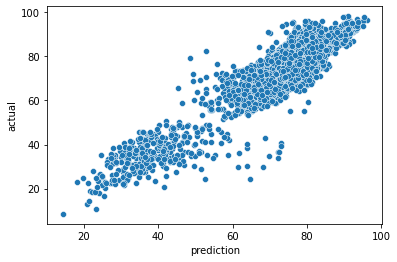

In [156]:
plot_error(y_test,y_pred_tes)

### Gradient Boosting

In [157]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 500, 1000,1500,2000]}

gbreg = GradientBoostingRegressor()

gb_rscv = RandomizedSearchCV(estimator=gbreg,
                      cv=5,
                      param_distributions=params,
                      scoring=make_scorer(r2_score, greater_is_better=True),
                      verbose=1,n_jobs=-1)


gb_rscv.fit(X_train, y_train)

gb_tunned= gb_rscv.best_estimator_

y_pred = gb_tunned.predict(X_train)
y_pred_tes =  gb_tunned.predict(X_test)
print("train score:",r2_score(y_train,y_pred))
print("train score:",r2_score(y_test,y_pred_tes))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/rahularora/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rahularora/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rahularora/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rahularora/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed w

train score: 0.8623868093722021
train score: 0.8185676328868351


In [158]:
from sklearn.ensemble import ExtraTreesRegressor
exreg = ExtraTreesRegressor().fit(X_train, y_train)

y_tes = exreg.predict(X_test)


In [160]:
r2_score(y_test,y_tes)

0.8087325529622609

### Stacking

In [161]:
lasso = Lasso(alpha=0.05, random_state = 1,max_iter=100)

ENet = ElasticNet(alpha = 0.05, l1_ratio=0.9, random_state = 3,max_iter=100)

GBoost = GradientBoostingRegressor(n_estimators = 100,learning_rate=0.05,
                                   max_depth = 10, random_state=5)

model_rf = RandomForestRegressor(max_depth=17,n_estimators=100)

xgb =  xgb_tunned

exr  = ExtraTreesRegressor()

lightgbm = lgb.LGBMRegressor()


In [162]:
models = [lasso,ENet,GBoost,model_rf,xgb,lightgbm,exr]
scores={}
for model in models:
    print(model)
    model.fit(X_train,y_train)
    tr_pred = model.predict(X_test)
    scores[model] = r2_score(y_test,tr_pred)
    print(scores[model])

Lasso(alpha=0.05, max_iter=100, random_state=1)
0.5948952589940861
ElasticNet(alpha=0.05, l1_ratio=0.9, max_iter=100, random_state=3)
0.5949031289557895
GradientBoostingRegressor(learning_rate=0.05, max_depth=10, random_state=5)
0.8211543793471849
RandomForestRegressor(max_depth=17)
0.8245349118740545
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.8999999999999999, colsample_bynode=1,
             colsample_bytree=0.8999999999999999, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0

In [163]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [164]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_rf),
                                                 meta_model = lasso)


stacked_averaged_models.fit(X_train, y_train)

stacked_train_pred = stacked_averaged_models.predict(X_train)

#stacked_pred = np.expm1(stacked_averaged_models.predict(test_df))
print(r2_score(y_train, stacked_train_pred))

0.9072491099131763


In [166]:
stacked_test_pred = stacked_averaged_models.predict(X_test.reset_index(drop=True))

#stacked_pred = np.expm1(stacked_averaged_models.predict(test_df))
print(r2_score(y_test, stacked_test_pred))

0.8279731852255762


In [62]:
stacked_averaged_models.fit(X,y)

StackingAveragedModels(base_models=(ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                               max_iter=100, random_state=3),
                                    GradientBoostingRegressor(learning_rate=0.05,
                                                              max_depth=10,
                                                              random_state=5),
                                    RandomForestRegressor(max_depth=17)),
                       meta_model=Lasso(alpha=0.0005, max_iter=100,
                                        random_state=1))

In [63]:

test_pred = stacked_averaged_models.predict(test_data)
final_df=pd.DataFrame()
final_df['Property_ID'] = test_df['Property_ID']
final_df['Habitability_score']= np.exp(test_pred)

In [169]:
test_data.isna().sum()

Crime_Rate_max                  10500
power_backup_yes                    0
Dust_and_Noise                      0
Water_Supply_All time               0
nr_greater_than_3                   0
                                ...  
Traffic_Density_Score               0
Property_Type_Container Home        0
Property_Type_median            10500
Property_Area                       0
Dust_and_Noise_99th             10500
Length: 91, dtype: int64

In [168]:
# y1=stacked_averaged_models.predict(test_data)

y2=gb_tunned.predict(test_data)

y3= xgb_tunned.predict(test_data)

ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [64]:
final_df.to_csv('submission_stack2.csv',index=False)

### Deep Learning

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [19]:
normalizer.adapt(np.array(X_train))

2022-08-16 21:43:51.184289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-16 21:43:51.184901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-16 21:43:51.257504: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-16 21:43:51.343434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-16 21:43:51.362330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [20]:
print(normalizer.mean.numpy())

[[8.3453780e-01 8.9907875e+01 2.3337076e+00 9.0470383e+01 1.0362853e+01
  8.1436910e-02 1.3377912e+01 4.8496421e-02 7.3487831e+01 5.8932744e-02
  7.1591265e-02 1.3024281e-02 1.3954843e+03 7.5775566e+01 1.2124893e+02
  9.3621910e+01 5.1542944e-01 9.3563988e+01 7.3489365e+01 9.4102150e+01
  9.3762939e+01 6.3532410e+00 7.3481903e+01 6.9437431e+01 1.2051902e+01
  9.9503426e+01 3.7356000e+00 6.7484421e+01 8.1604424e+01 1.3697575e+01
  9.9000954e+01 1.4737397e-01 9.4044136e+01 4.8653993e-01 8.9510605e+01
  1.9648938e-01 8.2173615e+01 9.8824127e+01 7.5698410e+01 1.6868229e+01
  9.7702820e+01 6.9191002e+01 6.9524864e+01 4.9239060e-01 8.1948997e+01
  7.5088120e+01 6.8133385e+01 1.9713658e-01 5.2659750e-02 7.3488167e+01
  7.5714401e+01 6.9379066e+01 7.5349525e+01 8.8328859e-03 4.9407843e-01
  2.9362285e-01 7.3483528e+01 8.1782692e+01 1.3942485e+01 9.5621614e+00
  9.5538607e+00 9.0447083e+01 2.2746074e-01 8.2234940e+01 8.2269737e+01
  2.8943139e-01 9.8303177e+01 8.9739311e+01 7.3492180e+01 2.0647

In [21]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   1.     88.94    3.     90.9     9.94    0.     14.76    1.     71.4
     1.      0.      0.   1878.     74.34  151.     89.03    0.     96.21
    73.87   94.07   93.06    6.92   81.07   67.74   20.42   99.59    1.27
    35.09   86.69   18.74  100.      0.     94.11    1.     92.9     1.
    77.67   95.3    76.41    7.28  100.     57.23   71.      0.     80.52
    60.76   75.61    0.      0.     64.81   75.89   69.96   80.94    0.
     0.      0.     74.89   72.76   12.93    9.      7.28   90.51    0.
    82.94   82.35    1.     97.83   82.97   55.01    0.     87.6    96.66
     1.      9.94    0.      7.48   92.3    13.6     0.      0.      0.
     0.      5.     71.08   26.51]]

Normalized: [[ 0.45 -0.56  0.56  0.51 -0.15 -0.3   0.55  4.43 -0.56  4.   -0.28 -0.11
   0.24 -0.55  0.48 -2.83 -1.03  1.69  0.19 -0.07 -0.56  0.46  1.22 -0.56
   2.38  0.23 -3.1  -3.39  1.4   2.86  1.1  -0.42  0.09  0.68  1.3   2.02
  -2.65 -2.45  0.69 -1.78  1.57 -3.53  0.86 -0.98 -0.56 -

In [63]:
model = keras.Sequential([

      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

In [64]:
from keras import backend as K

def coeff_determination(y_true,y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [69]:
model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [70]:
%%time
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_data=(X_test,y_test),)

Epoch 1/100
   1/1111 [..............................] - ETA: 6:32 - loss: 665.9285 - mean_absolute_error: 17.4882

2022-08-16 22:55:22.732072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1109/1111 [============================>.] - ETA: 0s - loss: nan - mean_absolute_error: nan

2022-08-16 22:55:28.285452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1111/1111 [==============================] - 6s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
1111/1111 [==============================] - 6s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/100
1111/1111 [==============================] - 6s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/100
 413/1111 [==========>...................] - ETA: 3s - loss: nan - mean_absolute_error: nan

KeyboardInterrupt: 

In [84]:
num_col

['Property_Area',
 'Number_of_Windows',
 'Number_of_Doors',
 'Frequency_of_Powercuts',
 'Traffic_Density_Score',
 'Air_Quality_Index',
 'Neighborhood_Review',
 'Habitability_score']

In [89]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
#num_cols_x = list(set(num_col) - {'Habitability_score'})
poly_features=poly.fit_transform(X_train)


In [90]:
poly_features.shape

(35549, 3741)

In [88]:
train

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.0,3.0,1.0,1.27,1878.0,6.92,151.0,5.0,9.0,3.0,...,3526884.0,12995.76,283578.0,9390.0,47.8864,1044.92,34.60,22801.0,755.0,25.0
1,1.0,2.0,0.0,3.87,543.0,4.72,92.0,4.0,4.0,0.0,...,294849.0,2562.96,49956.0,2172.0,22.2784,434.24,18.88,8464.0,368.0,16.0
2,1.0,4.0,0.0,3.76,2263.0,7.27,166.0,3.0,16.0,0.0,...,5121169.0,16452.01,375658.0,6789.0,52.8529,1206.82,21.81,27556.0,498.0,9.0
3,1.0,2.0,1.0,3.37,325.0,2.96,47.0,3.0,4.0,2.0,...,105625.0,962.00,15275.0,975.0,8.7616,139.12,8.88,2209.0,141.0,9.0
4,1.0,3.0,0.0,4.73,719.0,7.20,141.0,4.0,9.0,0.0,...,516961.0,5176.80,101379.0,2876.0,51.8400,1015.20,28.80,19881.0,564.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35544,1.0,2.0,1.0,4.17,888.0,7.92,83.0,7.0,4.0,2.0,...,788544.0,7032.96,73704.0,6216.0,62.7264,657.36,55.44,6889.0,581.0,49.0
35545,1.0,3.0,0.0,3.83,173.0,5.33,531.0,1.0,9.0,0.0,...,29929.0,922.09,91863.0,173.0,28.4089,2830.23,5.33,281961.0,531.0,1.0
35546,1.0,1.0,0.0,4.15,660.0,7.39,101.0,4.0,1.0,0.0,...,435600.0,4877.40,66660.0,2640.0,54.6121,746.39,29.56,10201.0,404.0,16.0
35547,1.0,3.0,1.0,4.15,899.0,7.61,102.0,2.0,9.0,3.0,...,808201.0,6841.39,91698.0,1798.0,57.9121,776.22,15.22,10404.0,204.0,4.0


In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

# Set RANSAC hyperparameters
ransac = RANSACRegressor(LinearRegression(),
		max_trials=4, 		# Number of Iterations
		min_samples=2, 		# Minimum size of the sample
		loss='absolute_loss', 	# Metrics for loss
		residual_threshold=10 	# Threshold
		)

# Train model
ransac.fit(X_train, y_train)

RANSACRegressor(estimator=LinearRegression(), loss='absolute_loss',
                max_trials=4, min_samples=2, residual_threshold=10)

In [92]:
y_pred = ransac.predict(X_test)

In [94]:
r2_score(y_test,y_pred)

0.5572349231156636

In [16]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

for i in range(1,20,1):
    polynomial_features = PolynomialFeatures(degree=i)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                            ("linear_regression", linear_regression)])

    #Execution of the cross validation with the mean square error as a scoring parameter
    scores=cross_val_score(pipeline, X, y, cv=30, scoring='r2')
    
    #To get the mean square error, the 'scores' list needs to be negated
    mse_scores=-scores
    
    # The cross-validation evaluates the created models after each run. 
    # In order to obtain a representative evaluation of the regression method, the mean value is formed over the score values
    cross_validation_score_mse=mse_scores.mean()
    
    #Output of the mean square error
    print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))

MSE by cross validation of polynomial regression:-0.5630866447335372
